### トピックモデリング
- スクレイピング等取得したテキストデータに対してトピックモデルを適用し、トピック別にテキスト分類を試みる。

#### 参考
- [トピックモデル入門：WikipediaをLDAモデル化してみた](https://recruit.gmo.jp/engineer/jisedai/blog/topic-model/)
- [LDA（Latent Dirichlet allocation）トピックモデルの優しいご紹介〜Python](https://lunarwoffie.com/lda-topic-model/)

In [22]:
# import
import pandas as pd

import MeCab
tagger = MeCab.Tagger("-Ochasen")
import mojimoji
import os
import re
import urllib

from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA


In [23]:
# テキストデータの準備
data_dir = "../../data/trip_adviser/"
filename_1 = "2023-06-27_scraping_from_trip_adviser.csv"
filename_2 = "2023-06-28_scraping_from_trip_adviser.csv"
text_col = "review"
df_1 = pd.read_csv(data_dir + filename_1)
df_2 = pd.read_csv(data_dir + filename_2)

df = pd.concat(
    [df_1, df_2],
    axis=0,
    ignore_index=True
)
df = df[text_col]
df.drop_duplicates(inplace=True)
texts = df.tolist() # リストに格納
df


0                                                    風神雷神
1       東京駅に、新しいショップと飲食店が多数オープンしました。お菓子、お土産、寿司、肉などなど、と...
2                                               動く新幹線の見学に
3       東京駅地下に到着し、新幹線ホームに行く為切符を購入。新幹線に乗って何処かに行く訳ではなく新幹...
4                                         公認キャラクター「ドームくん」
                              ...                        
2135    東京観光の帰りに、東京駅中で駅弁を買おうと行って来ました、駅中は大変混雑していて、前もって購...
2136                                               よかったです
2137    東京駅が昔の姿にリニューアル？されたとＴＶで言ってたので東京に行ったついでに見に行きました。...
2138                                           新しい東京駅丸の内口
2139    改装オープンのニュースにひかれ、早速東京駅に行って来ました。朝の比較的早い時間でしたが、丸の...
Name: review, Length: 1773, dtype: object

### NLP前処理
- 形態素解析：動詞・名詞・形容詞のみを残す
- ストップワードの除外
- 大文字・小文字の統一<br>
※ 上記処理によりテキスト数が減る場合がある

In [24]:
def load_japanese_stopwords(
    path = "../../data/stopwords/japanese_stopwords.txt",
    url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt",
):
    if os.path.exists(path):
        print('A file already exists.')
    else:
        print('Downloading...')
        dir_path = re.search(r'^(\.{2}/.*/)', path).group(1)
        os.makedirs(dir_path, exist_ok=True)
        urllib.request.urlretrieve(url, path)
    return pd.read_csv(path, header=None)[0].tolist()

def tokenizer(
    text,
    stopwords,
):
    tokens = []
    node = tagger.parseToNode(str(text))
    while node:
        features = node.feature.split(',')
        surface = features[6]
        if (surface == '*') or (len(surface) < 1) or (surface in stopwords):
            node = node.next
            continue
        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')
        if proper_noun_flag:
            tokens.append(surface)
        elif noun_flag:
            tokens.append(surface)
        elif verb_flag:
            tokens.append(surface)
        elif adjective_flag:
            tokens.append(surface)
        node = node.next
    return " ".join(tokens)

def preprocess_japanese_texts_by_mecab(
    text_series,
    path,
    url,
):
    stopwords = load_japanese_stopwords(path=path, url=url)
    print(f"len(text_series): {len(text_series)}")
    text_series = pd.Series(map(lambda x, y: tokenizer(x, y), text_series, stopwords))
    print(f"len(text_series): {len(text_series)}")

    # Normalization
    text_series = text_series.map(lambda x: x.lower())
    text_series = text_series.map(mojimoji.zen_to_han)

    return text_series


path = "../../data/stopwords/japanese_stopwords.txt"
url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
df_preprocessed_mecab = preprocess_japanese_texts_by_mecab(
    text_series=df,
    path=path,
    url=url,
)
df_preprocessed_mecab


A file already exists.
len(text_series): 1773
len(text_series): 310


0                                                   風神雷神
1      東京駅 新しい ｼｮｯﾌﾟ 飲食店 多数 ｵｰﾌﾟﾝ する お菓子 お土産 寿司 肉 素敵 ...
2                                              動く 新幹線 見学
3      東京駅 地下 到着 する 新幹線 ﾎｰﾑ 行く 為 切符 購入 新幹線 乗る 何処 行く 訳...
4                                       公認ｷｬﾗｸﾀｰ ﾄﾞｰﾑ くん
                             ...                        
305                                             久しぶり 東京駅
306    久しぶり 東京駅 行く 赤 煉瓦 造り 建物 格調 ある 立派 観光客 方 たくさん おりる...
307                                                   芸術
308    新しい ﾘﾌｫｰﾑ する 中 しかる かりとる 歴史 感じる 佇まい 色 ﾃﾞｻﾞｲﾝ 全て...
309                  駅前 整う ｽﾃｰｼｮﾝ ｷﾞｬﾗﾘｰ 2階 模型 駅舎 変遷 分かる
Length: 310, dtype: object

### WordCloudによるデータ可視化
- 前処理後のデータを可視化

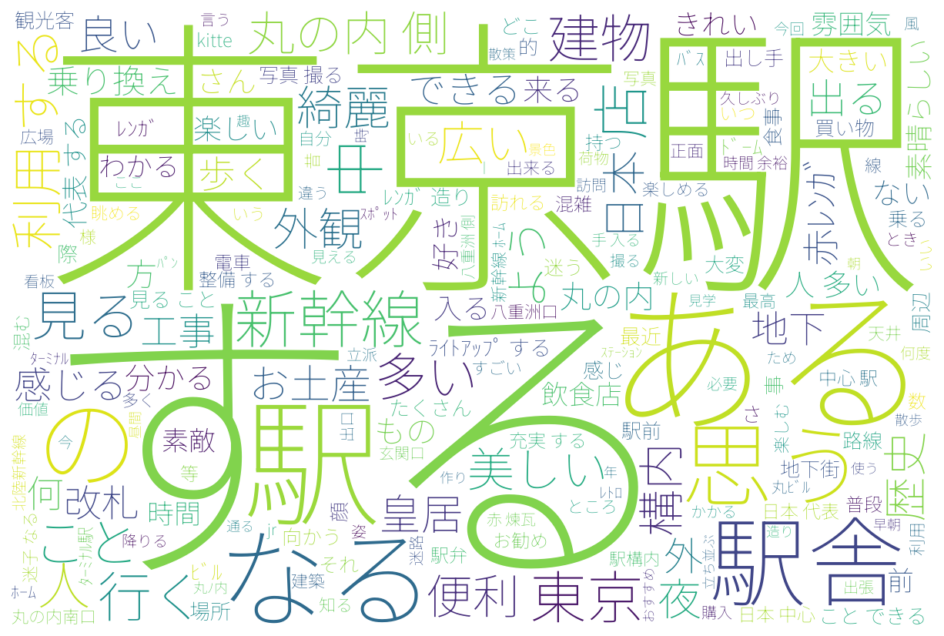

In [25]:
font_path="/Library/Fonts/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf"
font_property = matplotlib.font_manager.FontProperties(fname=font_path, size=24)
output_path = "../../output/trip_adviser/"
filename = "wordcloud_after_preprocessing.png"

def display_wordcloud(
    text_series,
    font_path,
    output_path,
    filename
):
    word_chain = ','.join(list(text_series.values))

    # Create a WordCloud object
    wordcloud = WordCloud(
        font_path=font_path,
        background_color="white",
        min_font_size = 10,
        max_words=200,
        width = 1200,
        height = 800,
        contour_width=3,
        contour_color='steelblue'
    ).generate(word_chain)

    # Visualize the word cloud
    os.makedirs(output_path, exist_ok=True)
    plt.figure(figsize = (12, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.savefig(output_path + filename, dpi = 300)
    plt.show()

display_wordcloud(
    text_series=df_preprocessed_mecab,
    font_path=font_path,
    output_path=output_path,
    filename=filename
)


### LDAトピックモデルの構築
- 前処理データからトピック・語彙のマトリクスを生成
    - scikit-learnのCounterVectorizerを適用して文書-単語のマトリクスを生成
    - TF-IDFを適用して単語出現頻度だけでなく、文書間の単語の希少性も考慮したマトリクスを生成
- マトリクスを基にLDAモデルを学習
    - GridSearchにて最適なトピックス数を検討(予めあたりをつけておくのがベター)
- トピック分類・可視化
    - トピックごとの単語可視化を行い、結果を検証

In [26]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df_preprocessed_mecab)
tfidf_vectorizer = TfidfTransformer()
tfidf_data = tfidf_vectorizer.fit_transform(count_data)
print(f"文書×単語のマトリクス：　{tfidf_data.toarray().shape}")


文書×単語のマトリクス：　(310, 1264)


Best Model's Params:  {'n_components': 2}
Best Log Likelihood Score:  -1658.223973980725
Model Perplexity:  2058.944267265587


/var/folders/k3/q1tnw64100vg6m1mqczvsbzh0000gn/T/ipykernel_50610/3513249138.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


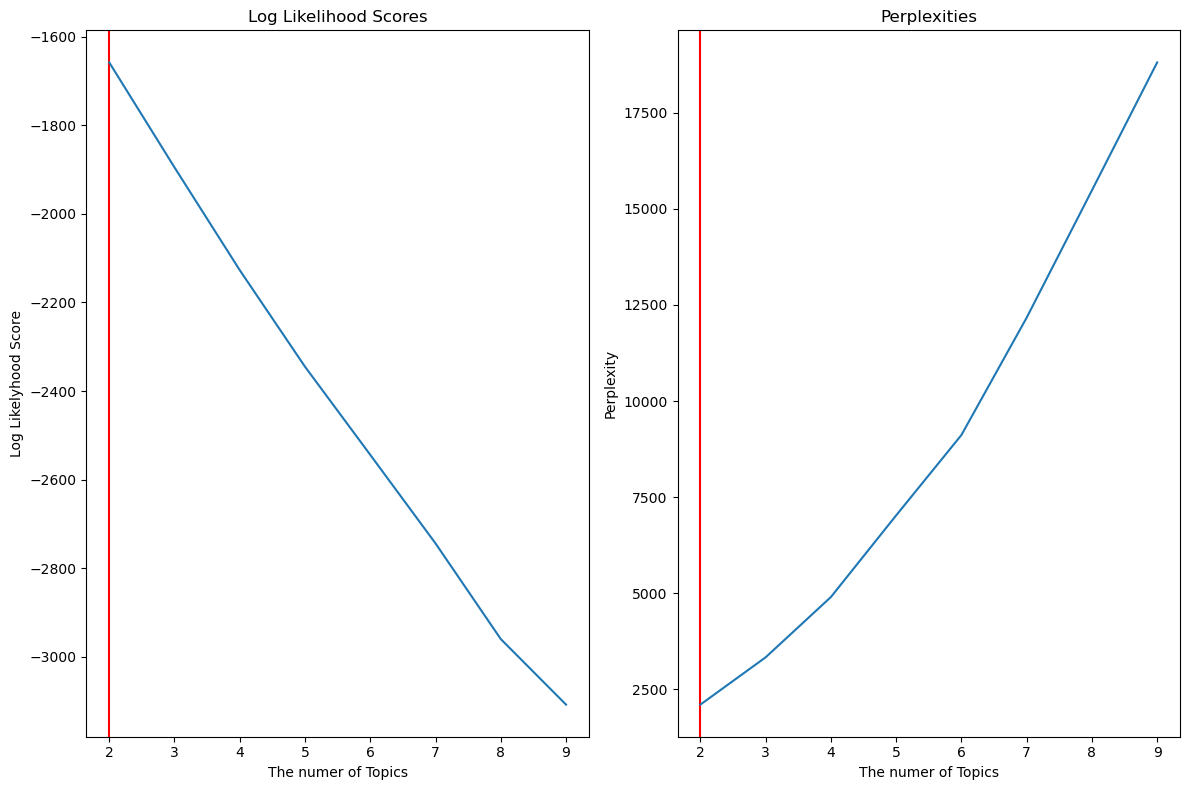

In [27]:
def gridsearch_best_model(tfidf_data, plot_enabled=True):
    # Define Search Param
    n_topics = list(range(2,10))
    search_params = {'n_components': n_topics}

    # Init the Model
    lda = LDA(
        max_iter=25, # Max learning iterations
        learning_method='batch',
        random_state=0, # Random state
        n_jobs = -1, # Use all available CPUs
    )

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)
    # Grid Search
    model.fit(tfidf_data)
    # Best Model
    best_lda_model = model.best_estimator_
    print("Best Model's Params: ", model.best_params_)
    print("Best Log Likelihood Score: ", model.best_score_)
    print("Model Perplexity: ", best_lda_model.perplexity(tfidf_data))

    # Get Log Likelyhoods from Grid Search Output
    log_likelihoods_score = [round(likelihood_score) for likelihood_score in model.cv_results_["mean_test_score"]]

    # Get perplexity
    perplexities = []
    for n_topic in n_topics:
        lda = LDA(
            n_components=n_topic,
            learning_method='batch',
            random_state=0,
            n_jobs=-1)
        lda.fit(tfidf_data)
        perplexities.append(lda.perplexity(tfidf_data))

    if plot_enabled:
        # define 1*2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

        # show the optimal number of topics by red lines
        best_topic = model.best_params_["n_components"]
        ax1.axvline(best_topic, color='red')
        ax2.axvline(best_topic, color='red')

        # plot log-likelihoods-scores
        ax1.plot(n_topics, log_likelihoods_score)
        ax1.set_title("Log Likelihood Scores")
        ax1.set_xlabel("The numer of Topics")
        ax1.set_ylabel("Log Likelyhood Score")

        # plot perplexities
        ax2.plot(n_topics, perplexities)
        ax2.set_title("Perplexities")
        ax2.set_xlabel("The numer of Topics")
        ax2.set_ylabel("Perplexity")

        fig.tight_layout()
        fig.savefig("../../output/trip_adviser/considering_likelihood_scores_and_perplexities.png", dpi = 300)
        fig.show()

    return best_lda_model

best_lda_model = gridsearch_best_model(tfidf_data)



Topic #0:
東京駅,する,ある,日本,丸の内,東京,見る,駅舎,綺麗,美しい,なる,建物,中心,外観,歴史,ﾗｲﾄｱｯﾌﾟ,ﾚﾝｶﾞ,思う,大きい,造り,素晴らしい,皇居,感じる,こと,赤ﾚﾝｶﾞ,工事,代表,素敵,撮る,良い,写真,きれい,久しぶり,迷路,もの,雰囲気,複雑,kitte,駅前,いつ,楽しい,終わる,ｱﾑｽﾃﾙﾀﾞﾑ,訪れる,行く,立派,できる,ﾄﾞｰﾑ,好き,広場,ﾚﾄﾛ,最高,感じ,整備,ﾋﾞﾙ,新しい,よう,改修工事,建築,いう,価値,ｵｼｬﾚ,たくさん,周辺,多い,溢れる,商業施設,すき,知る,自分,生まれ変わる,出る,通り,玄関,すごい,ﾀｰﾐﾅﾙ駅,ｼﾝﾎﾞﾙ,ｽﾃｰｼｮﾝ,観光客,煉瓦,眺める,それ,tokyo,存在感,ない,必見,出し手,行幸,正面,辰野金吾,昼間,ｽﾎﾟｯﾄ,風格,静か,立ち並ぶ,普段,ﾒｲﾝ,早朝,みたい,見える

Topic #1:
新幹線,する,利用,広い,便利,東京駅,ある,乗り換え,入る,多い,構内,こと,なる,分かる,充実,わかる,時間,玄関口,買い物,地下街,駅弁,ﾀｰﾐﾅﾙ,お土産,さん,思う,行く,来る,改札,できる,食事,路線,北陸新幹線,出張,迷子,見学,大変,迷う,丸ﾉ内,歩く,ｲﾙﾐﾈｰｼｮﾝ,一杯,混む,駅ﾅｶ,地下,いい,不便,いる,言う,最近,余裕,何度,丸ﾋﾞﾙ,上越新幹線,どこ,混雑,訪問,よう,ｱｰﾄ,八重洲,巨大,ｼｮｯﾋﾟﾝｸﾞﾓｰﾙ,丸の内線,通勤,飲食店,現在,良い,必要,出口,出る,ない,成田,お勧め,向かう,持つ,何回,楽しめる,ﾅｶ,とき,なん,増える,楽しむ,ここ,駅中,出し手,改札口,荷物,芸術,揃う,赤い,駅ｽﾀﾝﾌﾟ,風神雷神,ｱｸｾｽ,降りる,乗る,多く,ﾊﾟﾝ,好き,ﾎｰﾑ,外国人観光客,貫通


/var/folders/k3/q1tnw64100vg6m1mqczvsbzh0000gn/T/ipykernel_50610/3735289359.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


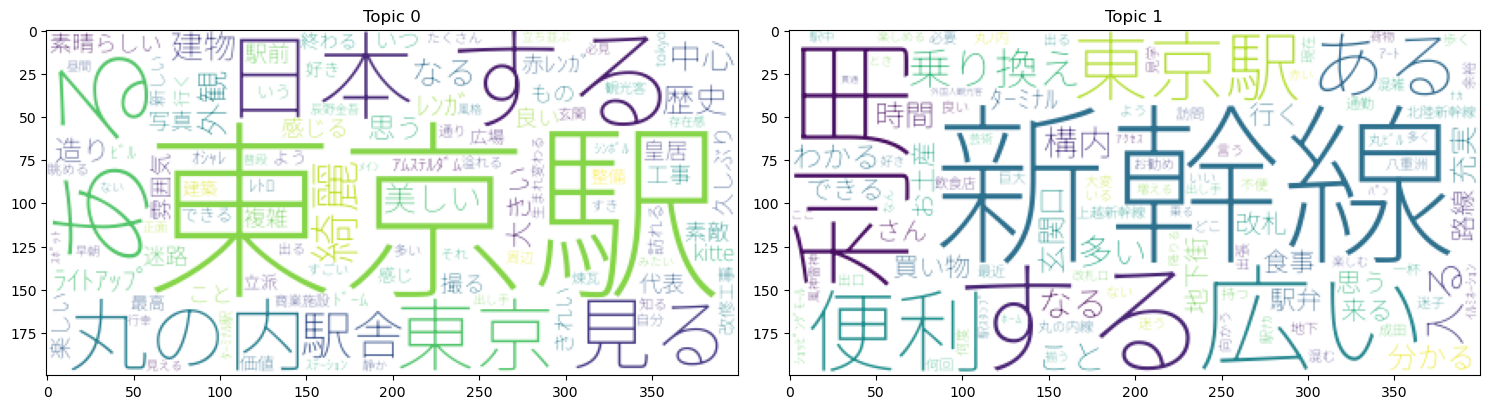

In [28]:
def print_topics(model, count_vectorizer, n_top_words):
    fig = plt.figure(figsize=(15,8))
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        long_string = ','.join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(f"\nTopic #{topic_idx}:\n{long_string}")
        topic_wordcloud(topic_idx, fig, long_string)
    # show plots
    fig.tight_layout()
    fig.savefig("../../output/trip_adviser/word_cloud_by_topics.png", dpi = 300)
    fig.show()

def topic_wordcloud(topic_idx, fig, long_string):
    ax = fig.add_subplot(1, 2, topic_idx + 1)
    wordcloud = WordCloud(font_path=font_path, background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    ax.imshow(wordcloud)
    ax.set_title('Topic '+str(topic_idx))

n_top_words = 100
print_topics(best_lda_model, count_vectorizer, n_top_words)


### 推論
- 構築したモデルを用いて新しいテキストデータのトピック分類を行い、適切に分類されたかを確認する

In [29]:
test_data = pd.Series(
    [
        '大阪駅周辺は再開発が盛んに行われており、建築物の現代化が急速に進んでいる。',
        '大阪中心部は鉄道路線がさらに充実する予定で、利便性のさらなる向上が見込まれる。'
    ]
)
processed_test_data = preprocess_japanese_texts_by_mecab(
    text_series=test_data,
    path="../../data/stopwords/japanese_stopwords.txt",
    url='http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
)
test_count_data = count_vectorizer.transform(processed_test_data)
test_tfidf_data = tfidf_vectorizer.transform(test_count_data)
doc_topic_mat = best_lda_model.transform(test_tfidf_data)
dominant_topic = np.argmax(doc_topic_mat, axis=1)

test_data_df = pd.DataFrame(test_data, columns=['text'])
test_data_df['topic_id'] = dominant_topic
display(test_data_df)


A file already exists.
len(text_series): 2
len(text_series): 2


,text,topic_id
0,大阪駅周辺は再開発が盛んに行われており、建築物の現代化が急速に進んでいる。,0
1,大阪中心部は鉄道路線がさらに充実する予定で、利便性のさらなる向上が見込まれる。,1
